https://www.kaggle.com/datasets/andrewmvd/data-analyst-jobs

In [1]:
import pandas as pd
import numpy as np

import re
from datetime import datetime

from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('DataAnalyst.csv')
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


## Cleaning the Dataset

In this dataset, null values are indicated by a "-1". Since this won't show up as a null value during data exploration, all values equalling -1 will be converted to NaNs. 

In [3]:
vals_to_replace = [-1, '-1', 'Unknown']
df.replace(vals_to_replace, None, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         2253 non-null   int64 
 1   Job Title          2253 non-null   object
 2   Salary Estimate    2252 non-null   object
 3   Job Description    2253 non-null   object
 4   Rating             1981 non-null   object
 5   Company Name       2252 non-null   object
 6   Location           2253 non-null   object
 7   Headquarters       2081 non-null   object
 8   Size               2048 non-null   object
 9   Founded            1593 non-null   object
 10  Type of ownership  2074 non-null   object
 11  Industry           1900 non-null   object
 12  Sector             1900 non-null   object
 13  Revenue            2090 non-null   object
 14  Competitors        521 non-null    object
 15  Easy Apply         80 non-null     object
dtypes: int64(1), object(15)
memory usage: 281.

In [4]:
# Sample of attribute exploration. This has been performed for all features, but only one sample attribute has been kept
# as to reduce the amount of space taken up by this analysis. 
df['Industry'].value_counts()

IT Services                            325
Staffing & Outsourcing                 323
Health Care Services & Hospitals       151
Computer Hardware & Software           111
Consulting                             111
                                      ... 
Truck Rental & Leasing                   1
News Outlet                              1
Catering & Food Service Contractors      1
Chemical Manufacturing                   1
Hotels, Motels, & Resorts                1
Name: Industry, Length: 88, dtype: int64

The attributes "Competitors" and "Easy Apply" will be dropped, as they contain mostly null values and are of little interest to this assessment. 

Moving forward, this analysis will make the presumption that job seekers generally care about some of these remaining attributes far more than others. The goal in this feature selection will be to best map this preference in a workable way. The additional attributes that will be dropped are:
- "Company Name": important to the job seeker, but not useful in clustering when there are no associated company features by which to compare companies to each other. 
- "Headquarters": Most job seekers likely do not hold strong preferences here.
- "Type of ownership": Heavily imbalanced and usually of relatively little consideration.
- "Revenue": A plurality of these are unknown, and startup status will be captured by other features. 

The follow attributes will be reworked into new ones:
- "Unnamed: 0": Will be renamed as "Job ID" for the purpose of this analysis. 
- "Job Title": Will need to be reduced into more easily useable bins, as many job titles are tantamount to each other and differ primarily in a semantic sense. 
- "Salary Estimate": Will be converted into a more useable numeric format consisting of the median between the two values.
- "Job Description": Will be vectorized as to be useable by data analysis tools.
- "Founded": Will be converted to "Company Age", then binned. This should be useful as job seekers likely have a preference in working for a recent startup or not. 

The 'Industry' attribute is a special case. While it could be rather useful, it is highly obfuscated by the fact that many jobs are listed through a staffing agency that are irrelevant to the job itself, and that generic categories like "IT Serivces" are often used. Additionally, the "Sector" attribute already captures much of the desired information. However, it will be useful to keep this attribute around in order to differentiate between jobs posted via a staffing agency and jobs posted otherwise. Therefore, null values in this column will simply be imputed with the mode of 'IT Services'

In [5]:
# Dropping the unnecessary columns
cols_to_drop = ['Competitors', 'Easy Apply', 'Company Name', 'Headquarters', 'Type of ownership', 'Revenue']
df.drop(cols_to_drop, axis=1, inplace=True)

# Renaming the ID column
df.rename(columns={'Unnamed: 0': 'Job ID'}, inplace=True)

# Filling the null values in the 'Industry' column with the mode.
df['Industry'].fillna('IT Services', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job ID           2253 non-null   int64 
 1   Job Title        2253 non-null   object
 2   Salary Estimate  2252 non-null   object
 3   Job Description  2253 non-null   object
 4   Rating           1981 non-null   object
 5   Location         2253 non-null   object
 6   Size             2048 non-null   object
 7   Founded          1593 non-null   object
 8   Industry         2253 non-null   object
 9   Sector           1900 non-null   object
dtypes: int64(1), object(9)
memory usage: 176.1+ KB


Since the 'Founded' attributes contains significantly more null values than the other columns, the null values will be imputed with the attribute median. The median is used in this case to account for the skew of the data, represented in the histogram below. 

Other values that are straightforward to impute, such as the numeric values of 'Rating', will be similarly handled. 

<AxesSubplot: title={'center': 'Founded'}, ylabel='Frequency'>

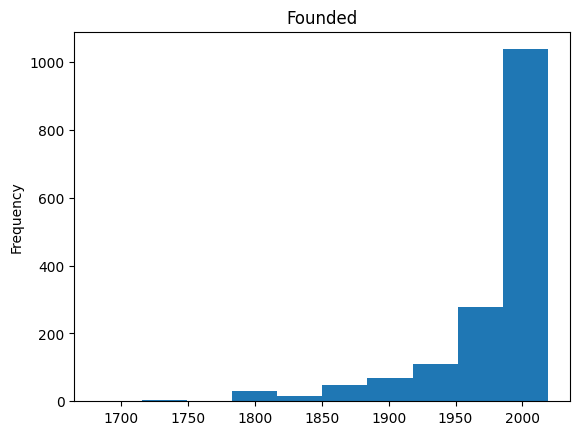

In [6]:
df['Founded'].plot(kind='hist', title='Founded')

<AxesSubplot: title={'center': 'Rating'}, ylabel='Frequency'>

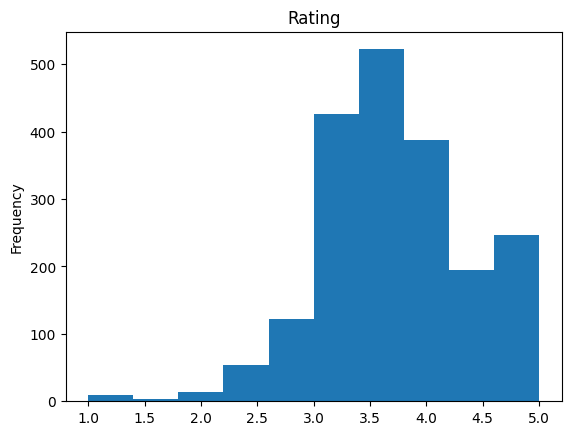

In [7]:
df['Rating'].plot(kind='hist', title='Rating')

In [8]:
df['Founded'].fillna(df['Founded'].median(), inplace=True)
df['Rating'].fillna(df['Rating'].median(), inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1891 entries, 0 to 2252
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           1891 non-null   int64  
 1   Job Title        1891 non-null   object 
 2   Salary Estimate  1891 non-null   object 
 3   Job Description  1891 non-null   object 
 4   Rating           1891 non-null   float64
 5   Location         1891 non-null   object 
 6   Size             1891 non-null   object 
 7   Founded          1891 non-null   float64
 8   Industry         1891 non-null   object 
 9   Sector           1891 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 162.5+ KB


Dropping the null values after imputation results in merely a 16% reduction of the dataset vs 31% without the imputation. 

Next, values in 'Salary Estimate' will be replaced with the mean of their range. A function will loop through the database here, as it is more complex than a simple mathematical computation of an existing numeric attribute. The 'findall' regex function makes this more difficult to weave into a Pandas replace function. 

In [9]:
for i in range(len(df['Salary Estimate'])):
    text = df.iloc[i, 2]
    new_vals = re.findall('[0-9]+𝐾*', text)
    new_vals = list(map(int, new_vals))
    new_mean = np.mean(new_vals)
    df.iloc[i, 2] = new_mean

df.head()

,Job ID,Job Title,Salary Estimate,Job Description,Rating,Location,Size,Founded,Industry,Sector
0,0,"Data Analyst, Center on Immigration and Justic...",51.5,Are you eager to roll up your sleeves and harn...,3.2,"New York, NY",201 to 500 employees,1961.0,Social Assistance,Non-Profit
1,1,Quality Data Analyst,51.5,Overview\n\nProvides analytical and technical ...,3.8,"New York, NY",10000+ employees,1893.0,Health Care Services & Hospitals,Health Care
2,2,"Senior Data Analyst, Insights & Analytics Team...",51.5,We’re looking for a Senior Data Analyst who ha...,3.4,"New York, NY",1001 to 5000 employees,2003.0,Internet,Information Technology
3,3,Data Analyst,51.5,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,"New York, NY",201 to 500 employees,2002.0,IT Services,Information Technology
4,4,Reporting Data Analyst,51.5,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,"New York, NY",501 to 1000 employees,2009.0,Sports & Recreation,"Arts, Entertainment & Recreation"


As seen above, 'Salary Estimate' values have been successfully replaced. Below, a distribution is shown, as well as some key metrics.

Average Salary: 72012.0
Median Salary: 68500.0


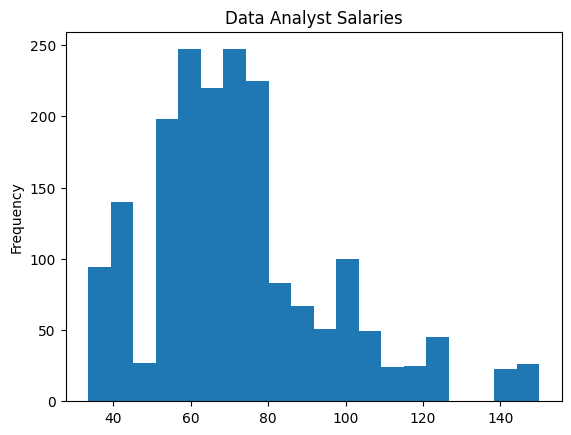

In [10]:
df['Salary Estimate'].plot(kind='hist', title='Data Analyst Salaries', bins=20)
sal_mean = df['Salary Estimate'].mean() * 1000
sal_med = df['Salary Estimate'].median() * 1000
print(f'Average Salary: {np.round(sal_mean)}\nMedian Salary: {sal_med}')

Moving onto 'Job Title', the below list gives the 25 most frequent job titles. The primary keywords indicating seniority are used to remape the values of the column into a binary senior/non-senior variable. This removes particularities of naming conventions and makes job titles more comparable. The is a risk here that the non-senior title also contains more senior positions, but this is mitigated by the fact that the imputed senior title should be very pure. 

In [11]:
df['Job Title'].value_counts()[:25]

Data Analyst                            333
Senior Data Analyst                      77
Junior Data Analyst                      30
Business Data Analyst                    25
Data Analyst Junior                      17
Sr. Data Analyst                         17
Data Quality Analyst                     17
Data Analyst II                          14
Lead Data Analyst                        13
Data Governance Analyst                  13
Data Reporting Analyst                   12
Data Analyst I                           10
Data Analyst III                         10
Sr Data Analyst                           9
Financial Data Analyst                    9
Marketing Data Analyst                    7
SQL Data Analyst                          7
Data Management Analyst                   7
Data Security Analyst                     6
Data Warehouse Analyst                    6
Technical Data Analyst                    6
Clinical Data Analyst                     5
Product Data Analyst            

In [12]:
sr_titles = ['senior', 'sr', 'ii', 'iii', '2', '3']

# Removes puncuation from job title, converts to lowercase, and splits into a list of individual words. 
df['Job Title'] = df['Job Title'].str.replace(r'[^\w\s]+', '', regex=True)
df['Job Title'] = df['Job Title'].str.lower()
df['Job Title'] = df['Job Title'].str.split(' ')

# Checks if a keyword denoting seniority is present and replaces title with one of two values.
df['Job Title'] = df['Job Title'].apply(lambda x: 1 if [i for i in x if i in sr_titles] else 0)

# Renaming to account for a boolean variable
df.rename(columns={'Job Title': 'Senior Position'}, inplace=True)
df['Senior Position'].value_counts()

0    1465
1     426
Name: Senior Position, dtype: int64

'Founded' will be converted to company age 

In [13]:
# Obtains the current year and replaces the year founded with the company age.
current_year = datetime.now().year
df['Founded'] = current_year - df['Founded']
df.rename(columns={'Founded': 'Company Age'}, inplace=True)

# Bins the values by quartile.
#df['Company Age'] =  pd.qcut(df['Company Age'], q=4)

df.head()

,Job ID,Senior Position,Salary Estimate,Job Description,Rating,Location,Size,Company Age,Industry,Sector
0,0,0,51.5,Are you eager to roll up your sleeves and harn...,3.2,"New York, NY",201 to 500 employees,62.0,Social Assistance,Non-Profit
1,1,0,51.5,Overview\n\nProvides analytical and technical ...,3.8,"New York, NY",10000+ employees,130.0,Health Care Services & Hospitals,Health Care
2,2,1,51.5,We’re looking for a Senior Data Analyst who ha...,3.4,"New York, NY",1001 to 5000 employees,20.0,Internet,Information Technology
3,3,0,51.5,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,"New York, NY",201 to 500 employees,21.0,IT Services,Information Technology
4,4,0,51.5,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,"New York, NY",501 to 1000 employees,14.0,Sports & Recreation,"Arts, Entertainment & Recreation"


Next, location will be reduced to a simple state category rather than specifying the city. This will reduce the granularity, but that will likely be more useful given that the dataset is not large enough to make use of higher granularity. 

In [14]:
df['Location'] = df['Location'].str.split(', ')
df['Location'] = df['Location'].apply(lambda x: x[-1])
df.head()

,Job ID,Senior Position,Salary Estimate,Job Description,Rating,Location,Size,Company Age,Industry,Sector
0,0,0,51.5,Are you eager to roll up your sleeves and harn...,3.2,NY,201 to 500 employees,62.0,Social Assistance,Non-Profit
1,1,0,51.5,Overview\n\nProvides analytical and technical ...,3.8,NY,10000+ employees,130.0,Health Care Services & Hospitals,Health Care
2,2,1,51.5,We’re looking for a Senior Data Analyst who ha...,3.4,NY,1001 to 5000 employees,20.0,Internet,Information Technology
3,3,0,51.5,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,NY,201 to 500 employees,21.0,IT Services,Information Technology
4,4,0,51.5,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,NY,501 to 1000 employees,14.0,Sports & Recreation,"Arts, Entertainment & Recreation"


Note that while 'Company Age' is scaled logarithmically, salary estimate is not. This is meant to give more weight to the salary component in clustering, as that is typically of greater interest to candidates than the age of the company.

In [92]:
# Dropping the ID as well as the lengthy job descriptions text for now.
#df_kmodes = df.drop(['Job ID', 'Job Description'], axis=1)

# Dropping the attributes that pertain to the specific job posting to look for clustering in the companies.
df_kmodes = df.drop(['Job ID', 'Senior Position', 'Job Description'], axis=1)
df_kmodes.drop(df_kmodes[df_kmodes['Industry'] == 'Staffing & Outsourcing'].index, inplace=True)

# Now that 'Industry' has been used to drop staffing companies, it will be dropped due to the aforementioned reasons.
df_kmodes.drop('Industry', axis=1, inplace=True)

# Normalizing the more variable numeric features by taking their logs.
df_kmodes['Company Age'] = np.log(df_kmodes['Company Age'].tolist())
#df_kmodes['Salary Estimate'] = np.log(df_kmodes['Salary Estimate'].tolist())

df_kmodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 2252
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Salary Estimate  1571 non-null   object 
 1   Rating           1571 non-null   float64
 2   Location         1571 non-null   object 
 3   Size             1571 non-null   object 
 4   Company Age      1571 non-null   float64
 5   Sector           1571 non-null   object 
dtypes: float64(2), object(4)
memory usage: 85.9+ KB


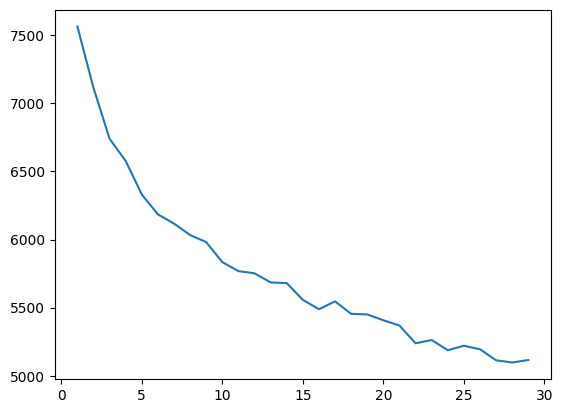

In [93]:
kmodes_costs = []
k_range = range(1, 30)

for k in k_range:
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(df_kmodes)
    kmodes_costs.append(kmode.cost_)
    
plt.plot(k_range, kmodes_costs)

The elbow plot doesn't show a clear hinge that would indicate leveling off. This is likely due to the fact that the clusters have quite a large amount of natural overlap, which would be expected with this dataset. For example, even if high-paying companies tend to exist in California, many other high-paying companies exist in conceivably every state in this analysis. 

It is highly preferred to keep the number of clusters minimal if possible, for reasons of overfitting and interpretability. With this is mind, much of the sharpness of decline seems to end at around k=6, so that will be used moving forward. Analysis using a greater number of clusters can be assessed if desired.

Using this number of clusters, the data indicate some interesting trends. A few sample clusters of companies from the results are as follows:

#TODO: update these depending on which k is used.
- Cluster #0: High salary, decent ratings, located in California, relatively small and young, associated with IT.
- Cluster #2: Low salary, average ratings, located in Philadelphia, rather large, associated with healthcare.
- Cluster #5: Decent salary, high ratings, located in Texas, relatively small and young, associated with IT.

In [94]:
kmodes = KModes(n_clusters=6, init = "random", n_init = 5, verbose=0)
kmodes.fit_predict(df_kmodes)
kmodes_results = kmodes.cluster_centroids_

In [96]:
df_kmodes_results = pd.DataFrame(kmodes_results, columns=df_kmodes.columns)

# Converting the log-scaled attributes back to their original form.
#df_kmodes_results['Salary Estimate'] = np.exp(df_kmodes_results['Salary Estimate'].astype(float))
df_kmodes_results['Company Age'] = np.exp(df_kmodes_results['Company Age'].astype(float))

df_kmodes_results

,Salary Estimate,Rating,Location,Size,Company Age,Sector
0,59.5,3.8,TX,10000+ employees,26.0,Finance
1,72.0,3.9,CA,1001 to 5000 employees,21.0,Information Technology
2,56.0,3.0,CA,201 to 500 employees,26.0,Business Services
3,80.5,5.0,CA,51 to 200 employees,15.0,Information Technology
4,39.5,3.6,NY,1001 to 5000 employees,26.0,Health Care
5,68.0,3.7,TX,1 to 50 employees,26.0,Information Technology
